# 1. BUSINESS PROBLEM
---

## 1.1. Context

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

Problem description on Kaggle: [click here](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction/data) to more information.

Note: the example has Rs. i.e. Rupee, an Indian money sign. So, the problem potentially is from an indian company.

## 1.2.Understanding the problem

### 1.2.1. Motivation

An Insurance company wants to cross sell the health insurance with vehicle insurance.

### 1.2.2. Root cause of the problem

Ensuring optimal coverage for both health and vehicle-related contingencies poses a unique challenge in cross-selling insurance products. Identifying clients willing to accept vehicle insurance alongside their health coverage while also remaining cognizant of potential health and vehicle-related issues is paramount.

The primary objective lies in attracting clients who not only find value in bundling these insurances but also contribute to the profitability of the portfolio.

### 1.2.3. Solution format

- Granularity and problem type: ID classification of interested or not
- Potential solution methods: logistic regression, tree based models, KNN;
- Delivery format:
    - Client prediction of interest on vehicle insurance;
    - Possibility of *google sheets* to check the clients information and customize the priorization, not just by rank of customer profit.

# 2. IMPORTS
---

## 2.1. Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import shap
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import scikitplot as skplt

In [2]:
# Boruta numpy fix problem
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

## 2.2. Helper functions

In [28]:
def plot_percentage_by_category(df, category_col, target_col, figsize=(10, 6)):
    """
    Plots a bar plot showing the percentage of target = 1 by category, with bars representing 100% behind.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data.
    category_col (str): Column name for the categories (y-axis).
    target_col (str): Column name for the target values (x-axis).
    """
    # Change the category_col to str
    df[category_col] = df[category_col].astype(str)


    # Calculate the percentage of target = 1 for each category
    percentages = df.groupby(category_col)[target_col].mean() * 100

    # Calculate total count and percentage for each category relative to entire dataset
    total_count = df.groupby(category_col)[target_col].count()
    total_percentage = (total_count / df.shape[0]) * 100

    # Sort categories by descending order of percentages
    percentages = percentages.sort_values(ascending=False)
    total_percentage = total_percentage.reindex(percentages.index)  # Reindex to match order

    # Plotting
    plt.figure(figsize=figsize)  # Adjust the figure size as needed

    # Using Seaborn style and color palette
    sns.set_style("white")  # Remove grid and use white background

    # Light blue color for 100% bars
    color_100 = 'lightblue'

    # Single shade of blue for percentage bars
    color_percentage = 'steelblue'

    # Convert index to string for proper plotting
    categories = percentages.index.astype(str)

    # Plotting 100% bars
    bars_100 = plt.barh(categories, [100] * len(percentages), color=color_100, edgecolor='black')

    # Adding quantities and percentages on top of 100% bars
    for i, bar in enumerate(bars_100):
        category = categories[i]
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                 f'{total_count[category]} ({total_percentage[category]:.2f}%)',
                 va='center', ha='left', fontsize=10)

    # Plotting percentage bars
    bars = plt.barh(categories, percentages, color=color_percentage, edgecolor='black')

    # Adding percentages values inside the bars
    for bar in bars:
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%',
                 va='center', ha='left', fontsize=10)

    # Removing spines (borders)
    sns.despine()

    # Adding labels and title
    plt.xlabel('Percentage (%)')
    plt.ylabel(category_col)
    plt.title(f'Percentage of {target_col} = 1 by {category_col}')

    # Show plot
    plt.show()

def plot_box_kde_by_category(df, x, category):
    """
    Plots a boxplot and a KDE plot ((Kernel Density Estimate) for a specified 
    category in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data to be plotted.
    x : str
        The name of the column in the DataFrame to be plotted on the x-axis.
    category : str
        The name of the categorical column in the DataFrame to be plotted on the y-axis in the boxplot
        and used for hue in the kdeplot.

    Returns:
    --------
    None
        This function does not return any value. It directly creates and displays the plots.
    """
    fig, axes = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

    sns.boxplot(x=x, y=category, data=df, ax=axes[0], orient='h', fill=False)
    sns.kdeplot(x=x, hue=category, data=df, ax=axes[1], common_norm=False)
    fig.suptitle(f'{category} by {x} distribution')

    sns.despine()

def mann_whitney_test(sample1, sample2, alpha=0.05):
    """
    Perform the Mann-Whitney U test for two independent samples.

    Parameters:
    sample1 (list or array-like): The first sample of data.
    sample2 (list or array-like): The second sample of data.
    alpha (float): The significance level (default is 0.05).

    Returns:
    stat (float): The Mann-Whitney U statistic.
    p_value (float): The p-value associated with the test.
    result (str): The conclusion of the hypothesis test.
    """
    # Perform the Mann-Whitney U test
    stat, p_value = stats.mannwhitneyu(sample1, sample2)
    
    # Print the results
    print(f"Mann-Whitney U statistic: {stat}")
    print(f"p-value: {p_value}")

    # Interpret the result
    if p_value < alpha:
        result = "We reject the null hypothesis. The samples are significantly different."
    else:
        result = "We fail to reject the null hypothesis. There is no significant difference between the samples."

    print(result)
    return stat, p_value, result

def cramer_v(x, y):
    """
    Calculate Cramér's V statistic for categorical-categorical association.

    Cramér's V is a measure of association between two nominal variables, giving a value between 0 and 1.
    A value of 0 indicates no association between the variables, while a value of 1 indicates perfect association.

    Parameters:
    -----------
    x : array-like
        The first categorical variable.
    y : array-like
        The second categorical variable.

    Returns:
    --------
    float
        Cramér's V statistic.
        
    Notes:
    ------
    This function calculates Cramér's V with bias correction as described in Bergsma (2013).
    """
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    v = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

    return v

def cross_val_rescaling_evaluation(X, y, model, metrics, scalers, n_splits=5):
    """
    Perform cross-validation with specific rescaling for different variables and return the evaluation metrics.
    
    Parameters:
    - X: numpy array or pandas DataFrame, feature set.
    - y: numpy array or pandas Series, target variable.
    - model: scikit-learn estimator, the model to be evaluated.
    - metrics: list of functions, metric functions to evaluate model performance.
    - scalers: list of tuples, each tuple contains (scaler, list of column indices).
               Example: [(StandardScaler(), [0, 1]), (MinMaxScaler(), [2, 3]), (RobustScaler(), [4])]
    - n_splits: int, number of folds in cross-validation.
    - random_state: int, random state for reproducibility.
    
    Returns:
    - results_df: pandas DataFrame, evaluation scores for each metric.
    """
    
    # Define the column transformer with specified scalers
    transformers = [(scaler.__class__.__name__.lower(), scaler, cols) for scaler, cols in scalers]
    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
    
    # Create a pipeline that first applies the preprocessor and then the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Define the metric scorers
    scorers = {metric.__name__: make_scorer(metric) for metric in metrics}
    
    # Define cross-validation strategy
    kf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
    
    # Run cross-validation
    cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scorers, return_train_score=True)
    
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(cv_results)
    
    return results_df

def make_cv_model_results_df(models, X, y, metrics, scalers, n_splits=5):
    """
    Perform cross-validation with specific rescaling for different variables and return the evaluation metrics.
    
    Parameters:
    - X: numpy array or pandas DataFrame, feature set.
    - y: numpy array or pandas Series, target variable.
    - models: list of scikit-learn estimators, the model to be evaluated.
    - metrics: list of functions, metric functions to evaluate model performance.
    - scalers: list of tuples, each tuple contains (scaler, list of column indices).
               Example: [(StandardScaler(), [0, 1]), (MinMaxScaler(), [2, 3]), (RobustScaler(), [4])]
    - n_splits: int, number of folds in cross-validation.
    - random_state: int, random state for reproducibility.
    
    Returns:
    - results_df: pandas DataFrame, evaluation scores for each metric.
    """
    models_str = []
    
    precisions_cv = []
    recalls_cv = []
    f1s_cv = []
    roc_aucs_cv = []

    for model in models:
        models_str.append(model.__class__.__name__)
        results = cross_val_rescaling_evaluation(X, y, model, metrics, scalers, n_splits)

        # Get the mean and standard deviation of the metrics
        p = f'{round(results["test_precision_score"].mean(), 3)} +/- {round(results["test_precision_score"].std(), 3)}'
        r = f'{round(results["test_recall_score"].mean(), 3)} +/- {round(results["test_recall_score"].std(), 3)}'
        f = f'{round(results["test_f1_score"].mean(), 3)} +/- {round(results["test_f1_score"].std(), 3)}'
        roc = f'{round(results["test_roc_auc_score"].mean(), 3)} +/- {round(results["test_roc_auc_score"].std(), 3)}'

        # Add the results to the lists
        precisions_cv.append(p)
        recalls_cv.append(r)
        f1s_cv.append(f)
        roc_aucs_cv.append(roc)
    
    # Final DataFrame with results
    results_df = pd.DataFrame({
        'model': models_str,
        'roc_auc_cv': roc_aucs_cv,
        'precision_cv': precisions_cv,
        'recall_cv': recalls_cv,
        'f1_cv': f1s_cv
    })
    
    return results_df

def plot_cumulative_gain_of(models, X_test, y_test, figsize=(12, 8)):
    """
    Plots cumulative gain charts for multiple pre-trained models on a 2x3 grid of subplots.

    This function takes a list of pre-trained machine learning models, predicts the probabilities 
    on the provided test data, and plots the cumulative gain charts for each model on its respective 
    subplot within a 2x3 grid. 

    Parameters:
    ----------
    models : list
        A list of pre-trained machine learning models. Each model should have a `predict_proba` method.
    
    X_test : array-like or DataFrame of shape (n_samples, n_features)
        The test input samples.
    
    y_test : array-like of shape (n_samples,)
        The true labels for `X_test`.
    """
    model_dict = {model.__class__.__name__:model for model in models}

    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()

    for ax, (model_name, model) in zip(axes, model_dict.items()):

        # Predict proba
        y_pred_proba = model.predict_proba(X_test)

        # Cummulative gain curve
        skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba, ax=ax, title=model_name)

    plt.tight_layout()
    plt.show()


## 2.3. Loading data

I downloaded the dataset from Kaggle. However, to replicate a true operational environment, I uploaded the data to a specific server on Render and accessed it using SQL queries. 

All the process has been documented on "upload_and_get_data" folder and the official data have been stored on data/raw folder.


In [4]:
df = pd.read_csv('../data/raw/health_insurance_cross_sell.csv').sort_values('id')

# 3. DATA DESCRIPTION
---

|Variable|Definition|
|--------|----------|
|id|Unique ID for the customer|
|Gender|Gender of the customer|
|Age|Age of the customer|
|Driving_License|0 : Customer does not have DL, 1 : Customer already has DL|
|Region_Code|Unique code for the region of the customer|
|Previously_Insured|1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance|
|Vehicle_Age|Age of the Vehicle|
|Vehicle_Damage|1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past|
|Annual_Premium|The amount customer needs to pay as premium in the year|
|Policy_Sales_Channel|Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc|
|Vintage|Number of Days, Customer has been associated with the company|
|Response|1 : Customer is interested, 0 : Customer is not interested|

In [4]:
df.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
95113,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
444877,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
95114,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
381280,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
158524,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 3.1. Data dimension

In [5]:
print(f'Number of rows: {df.shape[0]};')
print(f'Number of columns: {df.shape[1]}.')

Number of rows: 508146;
Number of columns: 12.


## 3.2. Data types

In [6]:
df.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 3.3. Check NaN values

In [7]:
df.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 3.4. Check duplicates

In [8]:
print(f'There are {df.shape[0]} rows on DataFrame.')
print(f'There are {df['id'].nunique()} unique customers.')

There are 508146 rows on DataFrame.
There are 508146 unique customers.


## 3.5. Descriptive statistics

Before we start, I want to separate the numerical and categorical variables, just because the analysis to these sets are different.

In [9]:
# Defining the numerical and categorical dfs
num_attributes = df[['age', 'annual_premium', 'vintage']]


cat_attributes = df[['gender', 'driving_license', 'region_code', 'previously_insured', 
                     'vehicle_age', 'vehicle_damage', 'policy_sales_channel', 'response']]

# Showing these dataframes
print('Numerical attributes:')
display(num_attributes)

print('Categorical attributes:')
display(cat_attributes)

Numerical attributes:


,age,annual_premium,vintage
95113,44,40454.0,217
444877,76,33536.0,183
95114,47,38294.0,27
381280,21,28619.0,203
158524,29,27496.0,39
...,...,...,...
190348,26,30867.0,56
413067,38,28700.0,165
444876,21,29802.0,74
476538,71,62875.0,265


Categorical attributes:


,gender,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,policy_sales_channel,response
95113,Male,1,28.0,0,> 2 Years,Yes,26.0,1
444877,Male,1,3.0,0,1-2 Year,No,26.0,0
95114,Male,1,28.0,0,> 2 Years,Yes,26.0,1
381280,Male,1,11.0,1,< 1 Year,No,152.0,0
158524,Female,1,41.0,1,< 1 Year,No,152.0,0
...,...,...,...,...,...,...,...,...
190348,Female,1,37.0,1,< 1 Year,No,152.0,0
413067,Female,1,28.0,0,1-2 Year,Yes,122.0,0
444876,Male,1,46.0,1,< 1 Year,No,152.0,0
476538,Male,1,28.0,1,1-2 Year,No,26.0,0


### 3.5.1. Numerical attributes

In [10]:
# Creating the metrics dataframe
metrics = num_attributes.describe().T

# Creating the skewness and kurtosis of each variables
skews = num_attributes.apply(lambda x: x.skew()).T
kurtosis = num_attributes.apply(lambda x: x.kurtosis()).T

# Creating the range of min and max values
metrics['range'] = metrics['max'] - metrics['min']

# Adding the skews and kurthosis values on metrics dataframe
metrics['skew'] = skews
metrics['kurtosis'] = kurtosis

# Changing the index to a variable and renaming it
metrics.reset_index(inplace=True)
metrics.rename({'index':'attribute'}, axis=1, inplace=True)

# Changing the order of columns apresentation on dataframe
metrics = metrics[['attribute', 'min', '25%', '50%', '75%', 'max', 'range', 'mean', 
                   'std', 'skew', 'kurtosis']]
display(metrics)

,attribute,min,25%,50%,75%,max,range,mean,std,skew,kurtosis
0,age,20.0,25.0,36.0,49.00,85.0,65.0,38.808413,15.500179,0.672751,-0.564665
1,annual_premium,2630.0,24381.0,31661.0,39403.75,540165.0,537535.0,30554.453041,17146.574625,1.600176,30.047860
2,vintage,10.0,82.0,154.0,227.00,299.0,289.0,154.340123,83.668793,0.002639,-1.200259


- There is a high kurtosis on `annual_premium`. So, the data is concentrated in a small range i.e. low dispersion
- Our max value is Rs. 540,165, maybe it is normal to India
- The `vintage` doesn't complete 1 year

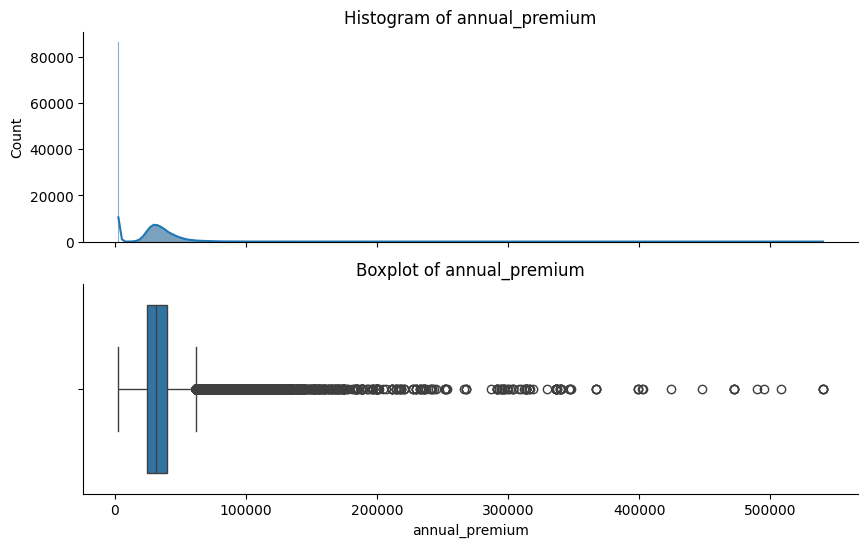

In [11]:
# Showing the annual_premium distribution
fig, axs = plt.subplots(2, sharex=True, figsize=(10, 6))
sns.histplot(data=df, x='annual_premium', ax=axs[0], kde=True)
axs[0].set_title('Histogram of annual_premium')

sns.boxplot(data=df, x='annual_premium', ax=axs[1])
axs[1].set_title('Boxplot of annual_premium')

sns.despine();

**MY FEELING**

There are a lot of data **next to zero** and a **high quantity of outliers**... we have to pay attention in this variable for the models. Some possible explanation of outliers:
- **High correlation with age or gender** and **quantity of people** relation. If there are a lot of young people or female gender in our data then make sense
- **Familiar health insurance**, making the `annual_premium` more expensive
- Input human error
- True value of health insurance

Note: female gender lives more compared to male, it's a statistic data.

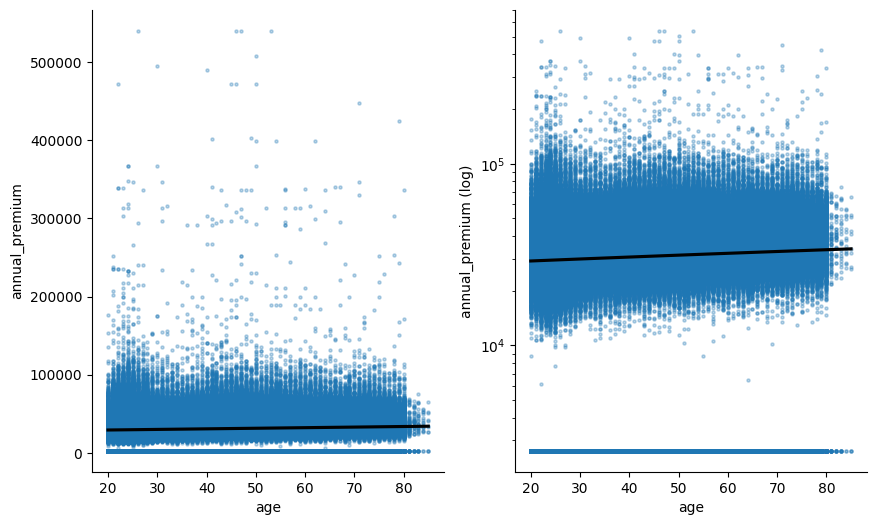

In [12]:
# Check the correlation of annual_premium and age
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
sns.regplot(data=df, x='age', y='annual_premium',
            scatter_kws={'s': 5, 'alpha': 0.3}, 
            line_kws={'color': 'black'}, ax=axs[0])

sns.regplot(data=df, x='age', y='annual_premium',
            scatter_kws={'s': 5, 'alpha': 0.3}, 
            line_kws={'color': 'black'}, ax=axs[1])
axs[1].set_ylabel('annual_premium (log)')
axs[1].set_yscale('log')

sns.despine();

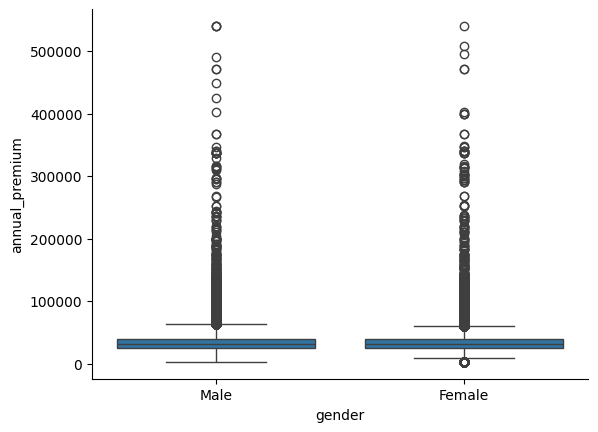

In [13]:
# Check annual_premium with gender
sns.boxplot(data=df, x='gender', y='annual_premium')
sns.despine();

From the figures, `annual_premium` has a low correlation with `age` and a low relationship with `gender`... maybe combining other features it generates another insight.

**SOME RESEARCH FROM ACKO HEALTH INSURANCE**

The webpage from Acko (indian health insurance company) provides comprehensive guidance on determining the appropriate amount of health insurance coverage for individuals and families. Here are the key points covered:

1. **Assessment Factors**: The amount of health insurance needed depends on several factors, including age, family size, lifestyle, medical history, and geographic location. Younger individuals and those with fewer dependents typically require less coverage compared to older individuals or those with larger families.

2. **Coverage Amount**: Acko suggests that the sum insured should ideally be at least half of one’s annual income. This ensures adequate coverage without overstretching finances. For families with elderly members or those with specific health needs, higher coverage plans are recommended, such as the ACKO Platinum Health Plan, which offers a higher sum insured and additional benefits like zero waiting periods and no claim deductions.

3. **Health Insurance Plans**: Acko offers various health insurance plans, including:
   - **ACKO Standard Health Plan**: Suitable for general needs with sums insured ranging from **Rs. 10 lakhs to Rs. 1 crore**, covering critical illnesses and pre and post-hospitalization expenses.
   - **ACKO Platinum Health Plan**: Designed for comprehensive coverage with options up to **Rs. 1 crore and unlimited sum insured**, zero co-payment, and multiple built-in add-ons.
   - **ACKO Platinum Super Top-up Plan**: Provides **high sum insured options** and covers critical illnesses, emergency evacuations, and multiple ambulance trips.

4. **Special Considerations**: For individuals with specific health needs or pre-existing conditions, plans like the ACKO Platinum Health Plan are ideal due to their extensive coverage and lack of waiting periods. Additionally, for families with elderly members, super top-up plans can provide additional security without requiring an additional primary insurance package.

5. **Government Schemes**: The Ayushman Bharat scheme (Pradhan Mantri Jan Arogya Yojana) provides free health care for economically weaker sections, offering coverage up to **Rs. 5 lakhs per family per year**, including pre and post-hospitalization expenses and pre-existing disease coverage.

Overall, the decision on the amount of health insurance to purchase should be based on a thorough evaluation of personal and family health needs, income levels, and potential future medical expenses. For detailed information, you can visit the Acko website directly at [Acko Health Insurance Guide](https://www.acko.com/health-insurance/deciding-how-much-health-insurance-you-need/).

Note: A crore (cr) denotes ten million and is equal to 100 lakh in the Indian numbering system. So 1 lakh is 100,000 rupees.

So, the values from this variable is normal to ACKO!

### 3.5.2. Categorical attributes

In [14]:
# Getting the categorical description
for cat in cat_attributes.columns:
    count = pd.DataFrame(cat_attributes[cat].value_counts())
    prop = pd.DataFrame(cat_attributes[cat].value_counts(normalize=True))
    
    grouped_info = count.join(prop)
    display(round(grouped_info, 3))

,count,proportion
gender,,
Male,274325,0.54
Female,233821,0.46


,count,proportion
driving_license,,
1,507097,0.998
0,1049,0.002


,count,proportion
region_code,,
28.0,141937,0.279
8.0,44900,0.088
46.0,26357,0.052
41.0,24400,0.048
15.0,17750,0.035
30.0,16276,0.032
29.0,14843,0.029
50.0,13657,0.027
3.0,12349,0.024


,count,proportion
previously_insured,,
0,275076,0.541
1,233070,0.459


,count,proportion
vehicle_age,,
1-2 Year,267015,0.525
< 1 Year,219805,0.433
> 2 Years,21326,0.042


,count,proportion
vehicle_damage,,
Yes,256248,0.504
No,251898,0.496


,count,proportion
policy_sales_channel,,
152.0,179523,0.353
26.0,106594,0.210
124.0,98299,0.193
160.0,29090,0.057
156.0,14313,0.028
...,...,...
143.0,1,0.000
84.0,1,0.000
41.0,1,0.000


,count,proportion
response,,
0,461436,0.908
1,46710,0.092


**NOTES**

- There are a lot of distinct `region_code`s and `policy_sales_channel`, so we can simplify these information
- We are working with **imbalanced data**, we have just **10% of interest on vehicle insurance**

**IMPORTANT QUESTION**

If someone doesn't have driving license, is he interested on vehicle insurance?

In [15]:
# Verification of driving license
pd.DataFrame(df.groupby(['driving_license', 'response'])['id'].count())

id
driving_license response        
0               0           1008
                1             41
1               0         460428
                1          46669

If someone doesn't have driving license, then probably he won't be interested on vehicle insurance, and if he is interested, it's because he is going to buy a car and will get the license soon.

Like we saw above, the quantity of responses equal to 1 when `driving_license` is 0 is so low. Thus I will drop the people that don't have driving license from our data and I won't include in the future models.

# 4. FEATURE ENGINEERING
---

Maybe we can create some variables from:
- `region_code`: `famous_region` i.e. most famous region code or not (28)
- `vehicle_age`: `vehicle_age2` i.e. "< 1 Year" and ">= 1 Year"
- `policy_sales_channel`: `famous_policy_sales_channel` i.e. most famous policy sales channels or not (152, 26 and 124)
- `annual_premium` / `vintage`: `hi_customer_profitability` i.e. health insurance customer by used days, giving an idea of customer actual profit for the company

The main purpose is just to simplify or improve our future models.

## 4.1. Mind map hypothesis

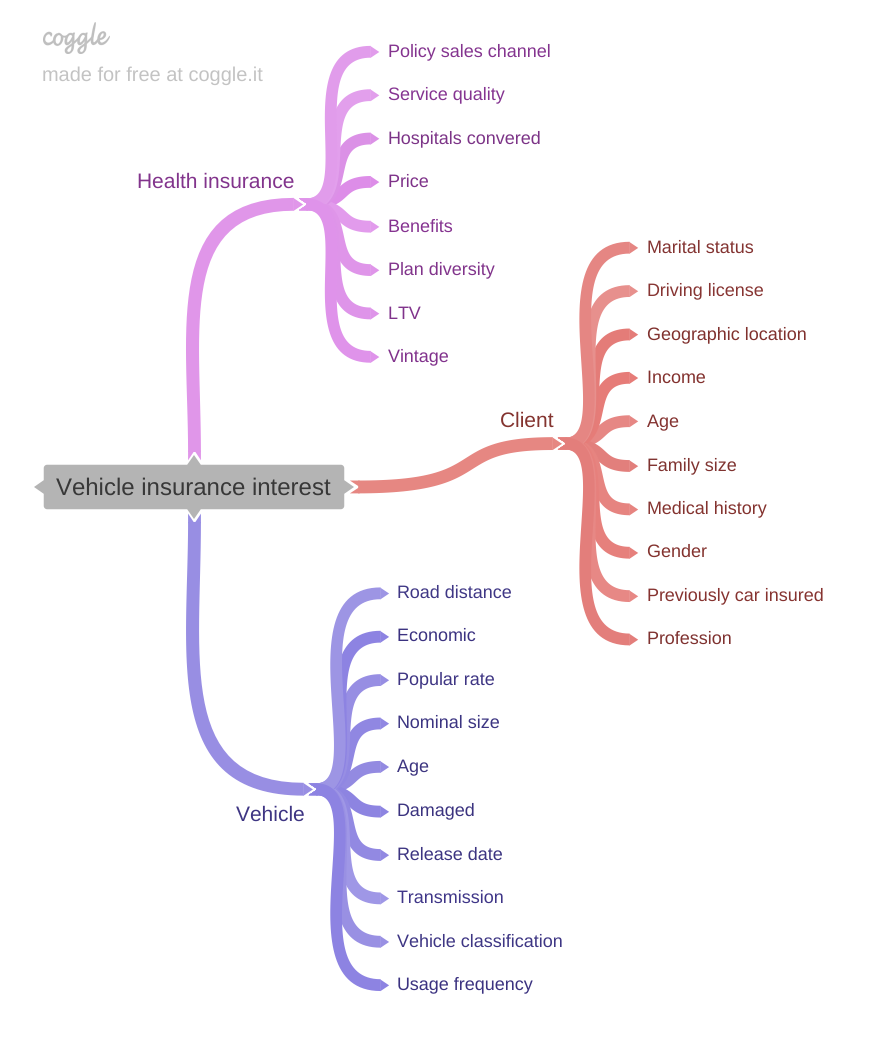

In [16]:
# Business mindmap
Image('../references/mind_map_hypothesis.png')

## 4.2. Creating hypothesis

### 4.2.1. Health insurance hypothesis

**1.** Different policy sales channel of health insurance doesn't change the vehicle insurance interest

**2.** High service quality of health insurance is essencial to make a conversion on vehicle insurance

**3.** The more hospitals included in health insurance, the greater the interest on vehicle insurance

**4.** The higher annual premium price on health insurance, the lower the interest on vehicle insurance

**5.** The more benefits included on health insurance, the greater the interest on vehicle insurance

**6.** The more diversity of health insurance plans, the greater the interest on vehicle insurance

**7.** The higher the customer's LTV on health insurance, the greater the interest in vehicle insurance

**8.** The higher vintage on health insurance, the greater the interest in vehicle insurance

### 4.2.2. Client hypothesis

**1.** Married customers have more interest on vehicle insurance

**2.** Customers living on famous regions are more interested on vehicle insurance

**3.** The higher income of customers, the greater the interest on vehicle insurance

**4.** Older customers have more interest on vehicle insurance

**5.** The greater the family size of customer, the greater the interest in vehicle insurance

**6.** Bad medical history makes more interest on vehicle insurance

**7.** There is a difference between genders when comparing the vehicle insurance interest

**8.** If the customer already has vehicle insurance, then the customers won't have more interest on the insurance of our company

**9.** Some of professions have more interest on vehicle insurance

### 4.2.3. Vehicle hypothesis

**1.** The lower road distance, the greater the interest on vehicle insurance
 
**2.** If the vehicle is economic, then the vehicle insurance interest is greater 

**3.** The higher popular rate of the vehicle, the greater the interest on vehicle insurance

**4.** The higher nominal size, the greater the interest on vehicle insurance

**5.** Customers with older vehicle have less interest on vehicle insurance

**6.** If the vehicle has been damaged, then the vehicle insurance interest is greater

**7.** The older realese date of the vehicle, the lower the interest on vehicle insurance

**8.** If the vehicle is automatic, then the vehicle insurance interest is greater

**9.** THe higher vehicle classification, the greater the interest on vehicle insurance

**10.** If the frequency of use of the vehicle is high, then the vehicle insurance interest is greater

## 4.3. Final hypothesis list

The criterion used here is if we have the data to answer the hypothesis. On the other hand, if we don't have them, we could ask for another sector of the company to get the new data.

Basically, we analyse the data that we have now.

**1.** Different policy sales channel of health insurance doesn't change the vehicle insurance interest

**2.** The higher annual premium price on health insurance, the lower the interest on vehicle insurance

**3.** The higher vintage on health insurance, the greater the interest in vehicle insurance

**4.** Customers living on famous regions are more interested on vehicle insurance

**5.** Older customers have more interest on vehicle insurance

**6.** There is a difference between genders when comparing the vehicle insurance interest

**7.** If the car has been insured, then the customers will have more interest on the insurance of the company

**8.** Customers with older vehicle have less interest on vehicle insurance

**9.** If the vehicle has been damaged, then the vehicle insurance interest is greater

**10.** Customers more profitable are more interested on vehicle insurance

## 4.4. Creating features

In [17]:
# Famous region
df['famous_region'] = 0
df.loc[df['region_code'] == 28, 'famous_region'] = 1

In [18]:
# Vehicle age 2
df['vehicle_age2'] = 0
df.loc[df['vehicle_age'].isin(['1-2 Year', '> 2 Years']), 'vehicle_age2'] = 1

In [19]:
# Famous policy sales channel
df['famous_policy_sales_channel'] = 0
df.loc[df['policy_sales_channel'].isin([152, 26, 124]), 'famous_policy_sales_channel'] = 1

In [20]:
# Health insurance customer profitability
df['hi_customer_profitability'] = df['annual_premium'].div(df['vintage']).fillna(0)

# 5. VARIABLES FILTERING
---

Like I've said, I'm going to filter out who doesn't have driving license.

In [21]:
# Filter who doesn't have driving license
df = df[df['driving_license'] == 1].drop('driving_license', axis=1)

In [22]:
# Saving the data for EDA section
df.to_csv('../data/interim/hi_cs_processed.csv', index=False)

# 6. EXPLORATORY DATA ANALYSIS (EDA)
---

In [4]:
# Importing the data
df_eda = pd.read_csv('../data/interim/hi_cs_processed.csv')

## 6.1. Univariate analysis

### 6.1.1. Response variable

In [24]:
count = pd.DataFrame(df_eda['response'].value_counts())
prop = pd.DataFrame(df_eda['response'].value_counts(normalize=True))

grouped_info = count.join(prop)
display(round(grouped_info, 3))

,count,proportion
response,,
0,460428,0.908
1,46669,0.092


Like I already said, we are working with imbalanced data. We have to use models that fit well with this kind of problems.

### 6.1.2. Numerical variables

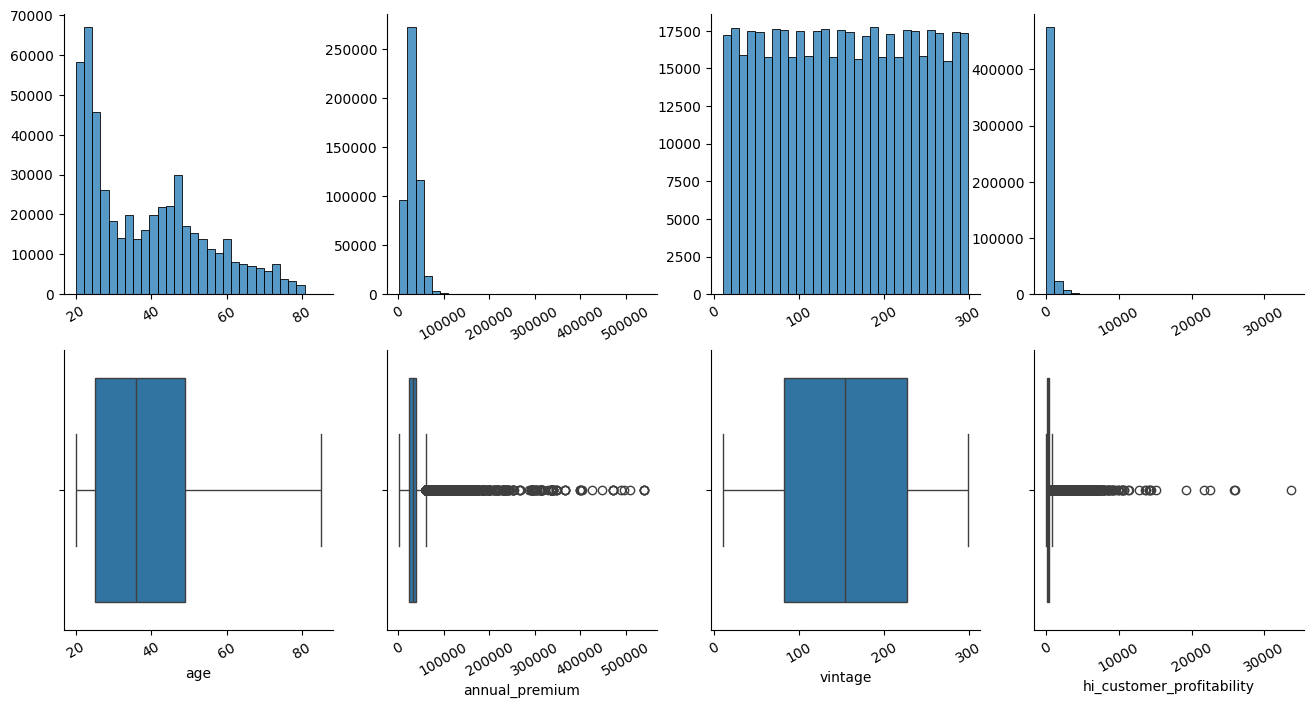

In [25]:
# Plotting all the histograms and boxplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

num_vars = ['age', 'annual_premium', 'vintage', 'hi_customer_profitability']

for i, var in enumerate(num_vars):
    sns.histplot(x=var, data=df_eda, ax=axes[i], bins=30)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for i, var in enumerate(num_vars):
    sns.boxplot(x=var, data=df_eda, ax=axes[i+4])

for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)

sns.despine();

- `age` has a right tail in distribution and the mode is between 20 and 25 years old
- `vintage` has a symmetric distribution, close to the uniform

### 6.1.3. Categorical variables

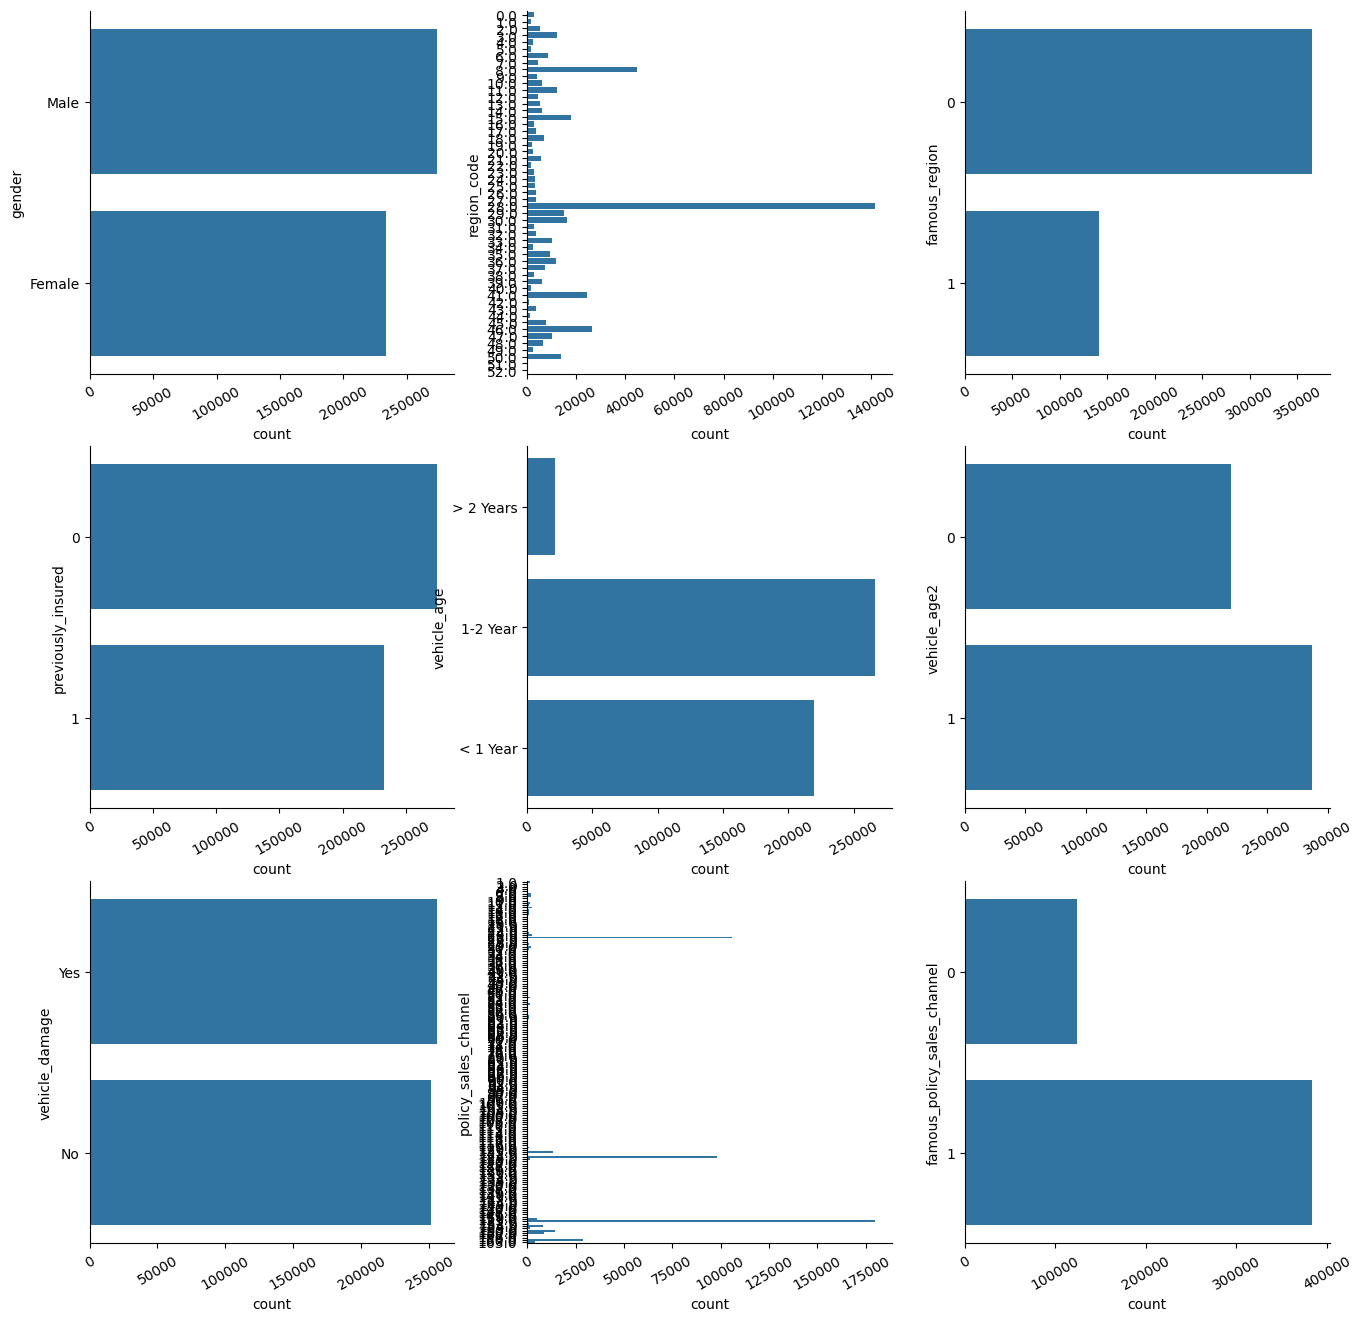

In [26]:
# Plotting the countplots
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = axes.flatten()

sns.countplot(y='gender', data=df_eda, ax=axes[0])
sns.countplot(y='region_code', data=df_eda, ax=axes[1])
sns.countplot(y='famous_region', data=df_eda, ax=axes[2])
sns.countplot(y='previously_insured', data=df_eda, ax=axes[3])
sns.countplot(y='vehicle_age', data=df_eda, ax=axes[4])
sns.countplot(y='vehicle_age2', data=df_eda, ax=axes[5])
sns.countplot(y='vehicle_damage', data=df_eda, ax=axes[6])
sns.countplot(y='policy_sales_channel', data=df_eda, ax=axes[7])
sns.countplot(y='famous_policy_sales_channel', data=df_eda, ax=axes[8])

for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)

sns.despine();

- There are a lot of distinct items on `region_code` and `policy_sales_channel`. These are flags to drop these variables from data
- The `famous_policy_channel` = 1 has the largest amount of data
- There is a low quantity of `vehicle_age` > 2 years, so adding this classification to >= 1 year, maybe it's a good idea


## 6.2. Bivariate analysis

### 6.2.1. $H_{1}$: Different policy sales channel of health insurance doesn't change the vehicle insurance interest

**FALSE**. We can observe that **different policy sales channels have different percentage of responses**.

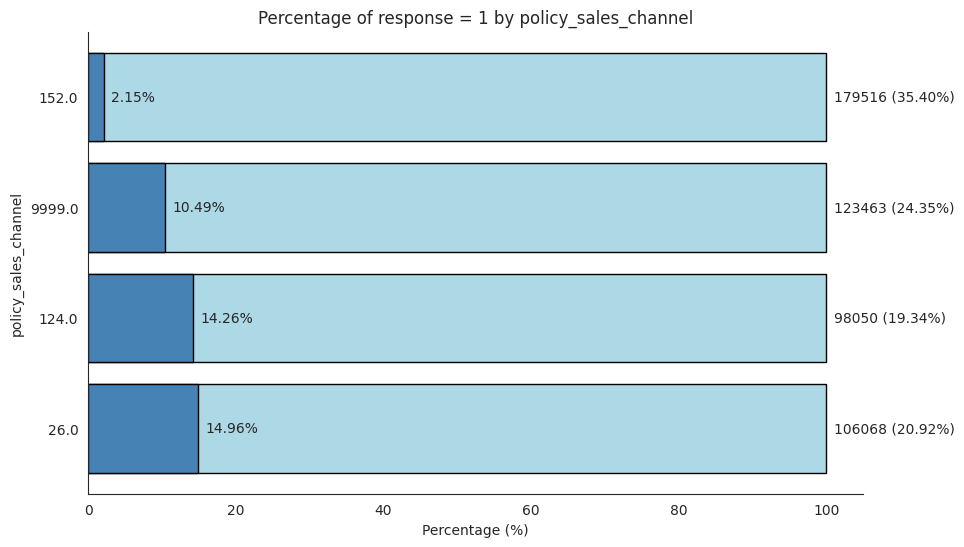

In [27]:
# Plotting the response by top 3 popular policy_sales_channel
top_three_pc = list(df_eda['policy_sales_channel']\
            .value_counts()\
            .reset_index()\
            .head(3)['policy_sales_channel'])

df_eda.loc[~df_eda['policy_sales_channel'].isin(top_three_pc), 'policy_sales_channel'] = 9999

plot_percentage_by_category(df_eda, 'policy_sales_channel', 'response')

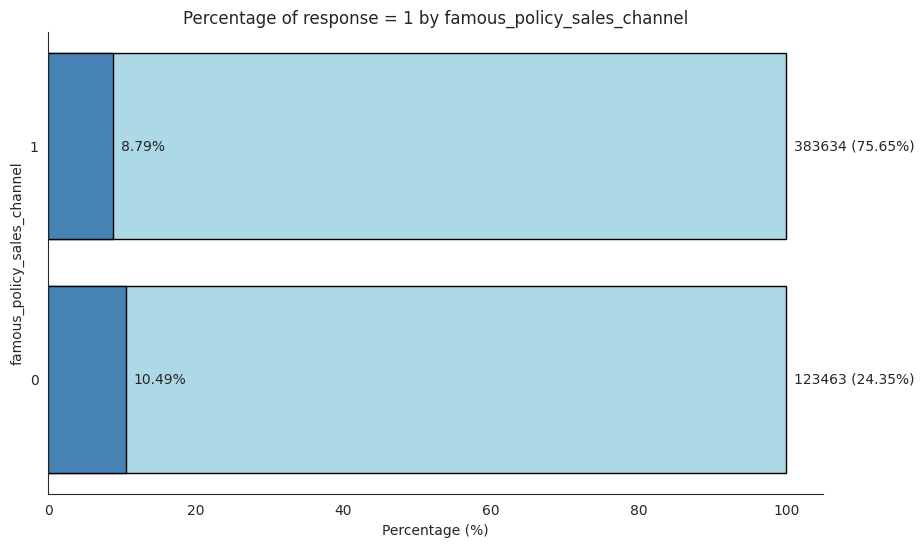

In [28]:
# Famous policy_sales_channel
plot_percentage_by_category(df_eda, 'famous_policy_sales_channel', 'response')

We can observe that **different policy sales channels have different percentage of responses**. Maybe I'll use the **top three divison** for modelling, because the classes have **near quantities** and the percentage of responses = 1 in code 152 is a little different compared between other codes.

### 6.2.2. $H_{2}$: The higher annual premium price on health insurance, the lower the interest on vehicle insurance

**TRUE**. There are more outliers on not interested people.

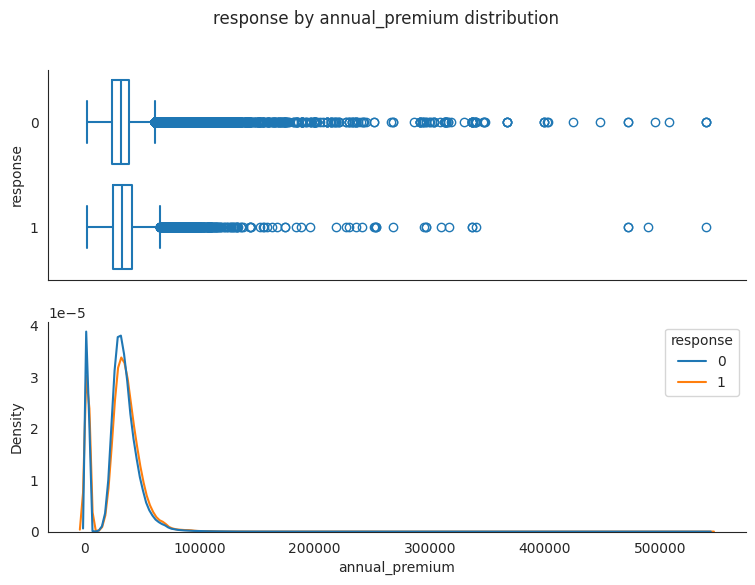

In [29]:
plot_box_kde_by_category(df_eda, 'annual_premium', 'response')

The distributions of `annual_premium` are very similar... The outliers is a little different, but they're few points...

In [30]:
mann_whitney_test(df_eda[df_eda['response'] == 1]['annual_premium'], 
                  df_eda[df_eda['response'] == 0]['annual_premium']);

Mann-Whitney U statistic: 11370428328.0
p-value: 1.7052591359565896e-96
We reject the null hypothesis. The samples are significantly different.


Okay, the outliers are making the difference between these samples...

### 6.2.3. $H_{3}$: The higher vintage on health insurance, the greater the interest in vehicle insurance

**FALSE**. Higher vintage on health insurance doesn't make any difference on interest in vehicle insurance.

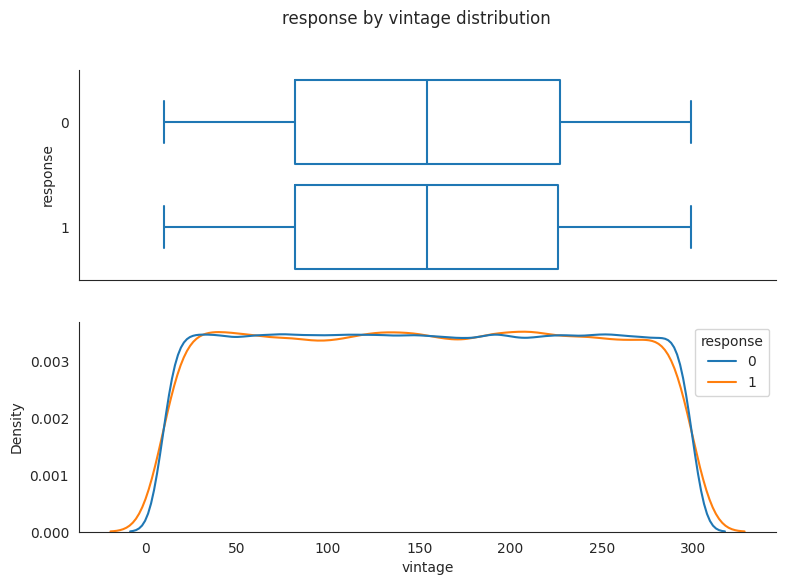

In [31]:
plot_box_kde_by_category(df_eda, 'vintage', 'response')

In [32]:
mann_whitney_test(df_eda[df_eda['response'] == 1]['vintage'], 
                  df_eda[df_eda['response'] == 0]['vintage']);

Mann-Whitney U statistic: 10726229956.5
p-value: 0.5585659779692942
We fail to reject the null hypothesis. There is no significant difference between the samples.


### 6.2.4. $H_{4}$: Customers living on famous regions are more interested on vehicle insurance

**TRUE**. If the customer is from `region_code` = 28, then the percentage of interest in vehicle insurance is greater, compared to other `region_code`s. 

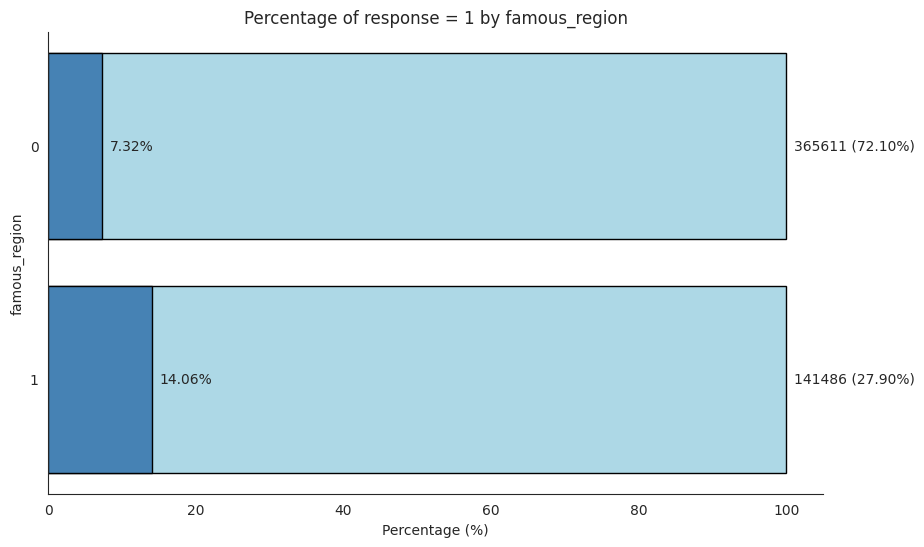

In [33]:
plot_percentage_by_category(df_eda, 'famous_region', 'response')

### 6.2.5. $H_{5}$: Older customers have more interest on vehicle insurance

**TRUE**. The older customers have more interest on vehicle insurance, when comparing the median from interest distributions.

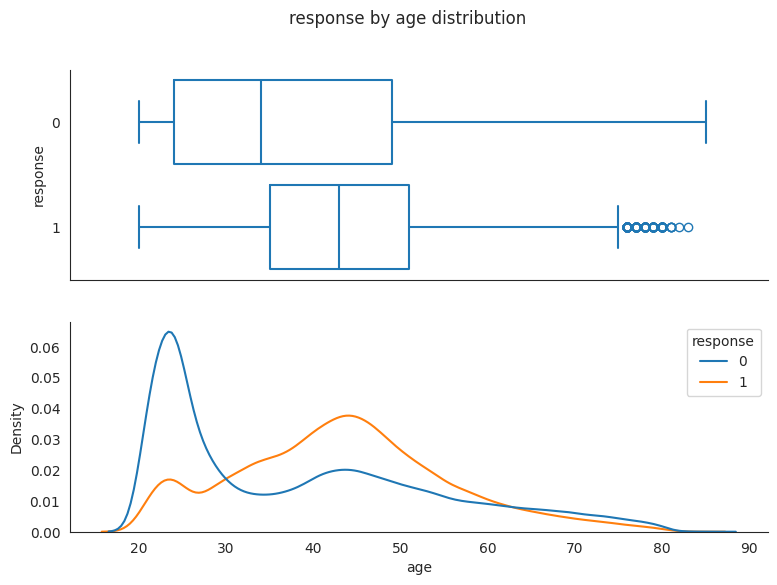

In [34]:
plot_box_kde_by_category(df_eda, 'age', 'response')

In [35]:
mann_whitney_test(df_eda[df_eda['response'] == 1]['age'],
                  df_eda[df_eda['response'] == 0]['age']);

Mann-Whitney U statistic: 13407779812.0
p-value: 0.0
We reject the null hypothesis. The samples are significantly different.


### 6.2.6. $H_{6}$: There is a difference between genders when comparing the vehicle insurance interest

**TRUE**. When comparing genders, there is a little difference on interest in vehicle insurance.

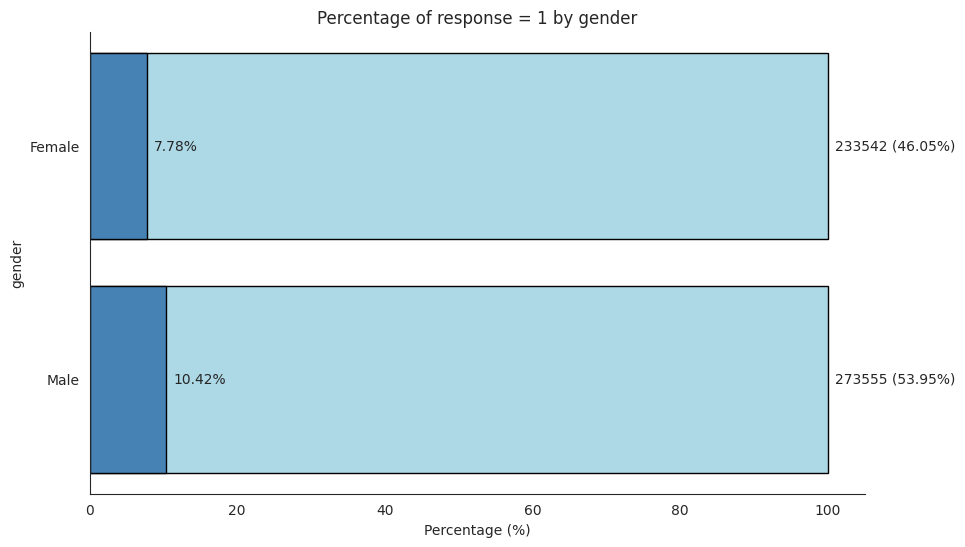

In [36]:
plot_percentage_by_category(df_eda, 'gender', 'response')

### 6.2.7. $H_{7}$: If the customer already has vehicle insurance, then the customers will have more interest on the insurance of our company

**TRUE**. If the customer already has vehicle insurance, the interest on our vehicle insurance is **lower**. So, the recomendation is to not offer our insurance to them.

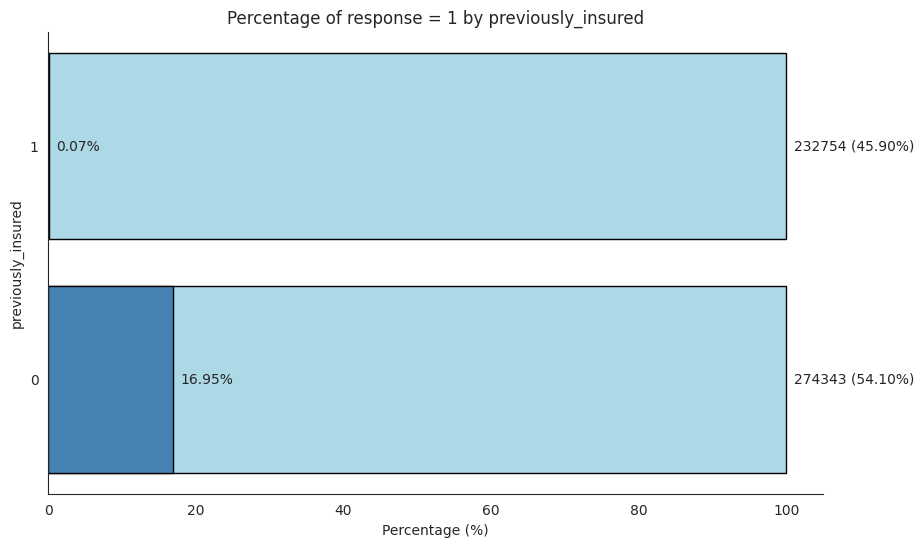

In [37]:
plot_percentage_by_category(df_eda, 'previously_insured', 'response')

### 6.2.8. $H_{8}$: Customers with older vehicle have less interest on vehicle insurance

**FALSE**. Customers with older vehicle have **more interest** on vehicle insurance. This is curious too, people with less vehicle age tend to preserve their vehicles earlier...

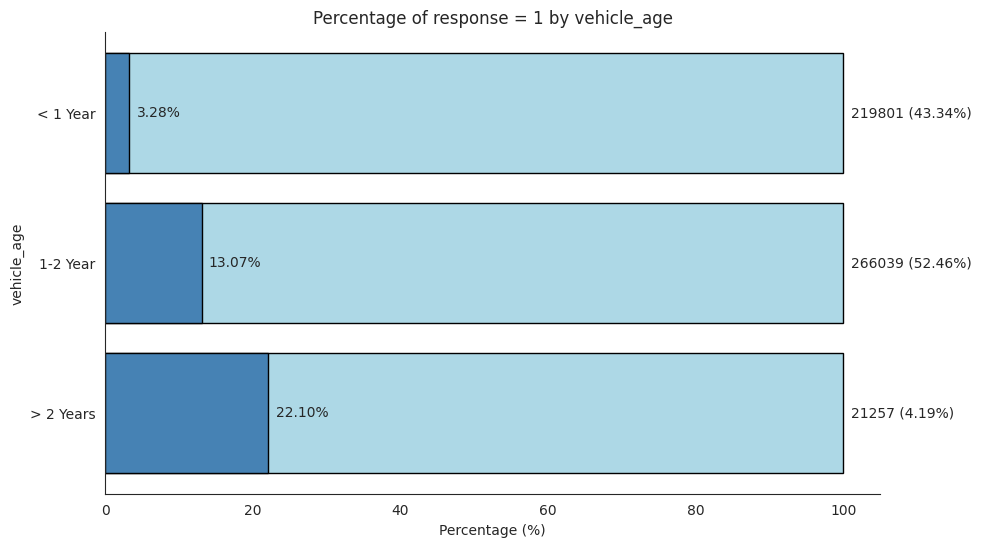

In [38]:
plot_percentage_by_category(df_eda, 'vehicle_age', 'response')

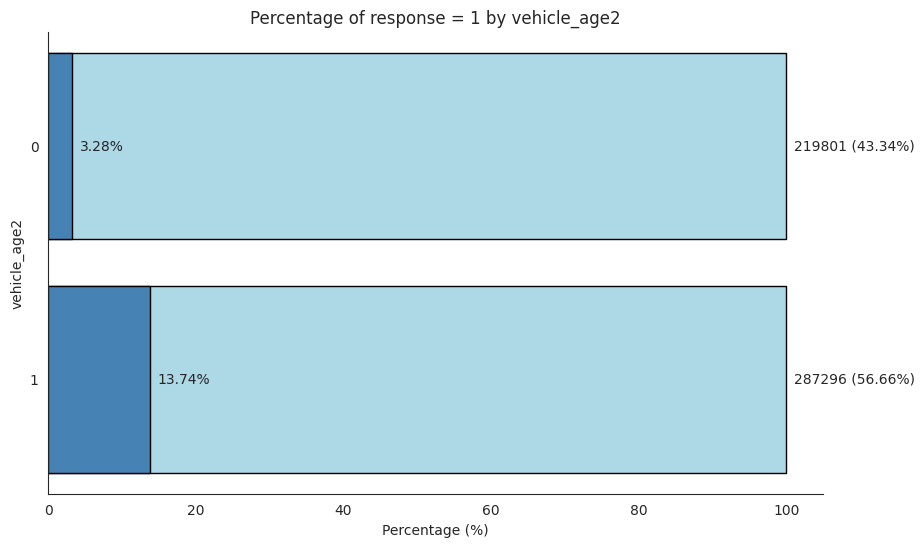

In [39]:
plot_percentage_by_category(df_eda, 'vehicle_age2', 'response')

### 6.2.9. $H_{9}$: If the vehicle has been damaged, then the vehicle insurance interest is greater

**TRUE**. If the vehicle has been damaged, normally people want a vehicle insurance.

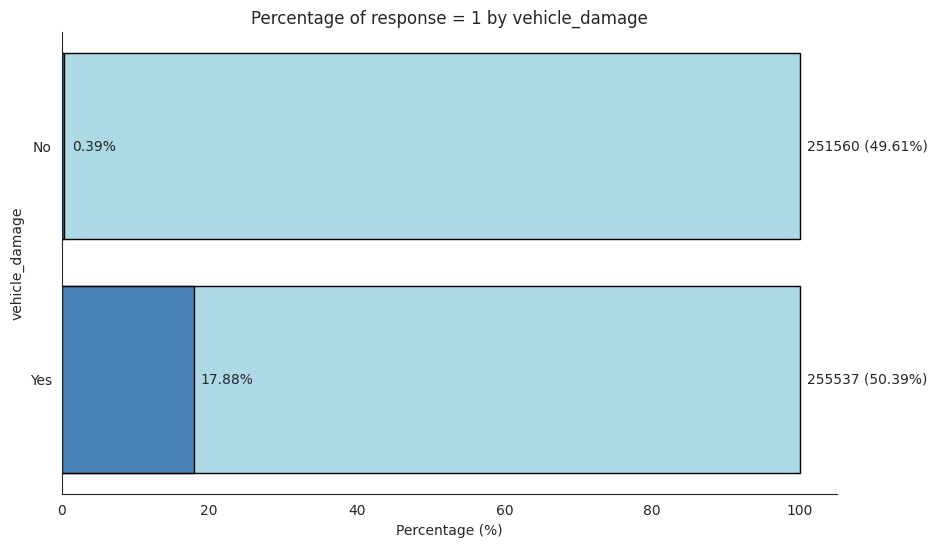

In [40]:
plot_percentage_by_category(df_eda, 'vehicle_damage', 'response')

### 6.2.10. $H_{10}$: Customers more profitable are more interested on vehicle insurance

**FALSE**. Customers less profitable are more interested on vehicle insurance, but the interest distributions are very similar... Maybe this variable isn't important.

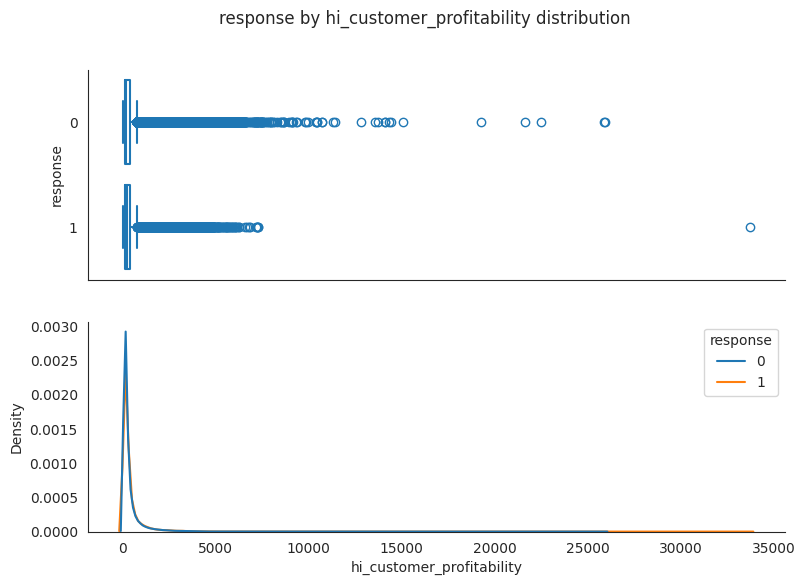

In [41]:
plot_box_kde_by_category(df_eda, 'hi_customer_profitability', 'response')

In [42]:
mann_whitney_test(df_eda[df_eda['response'] == 1]['hi_customer_profitability'],
                  df_eda[df_eda['response'] == 0]['hi_customer_profitability']);

Mann-Whitney U statistic: 10928019486.0
p-value: 9.867692640435383e-10
We reject the null hypothesis. The samples are significantly different.


The same case of `annual_premium`...

### 6.2.11. EDA feature importances

|Variable|Importance|
|--------|----------|
|previously_insured|High|
|vehicle_damage|High|
|vehicle_age2|High|
|age|Medium|
|famous_region|Medium|
|policy_sales_channel2*|Medium|
|gender|Medium|
|annual_premium|Low|
|vintage|Low|
|hi_customer_profitability|Low|

*: I'll create `policy_sales_channel2`, it'll be the top three most famous `policy_sales_channel` and the other channels classification.

**Note:** If the car has vehicle insurance, this would be a business rule and not a model feature. `previously_insured` will bias our model.

## 6.3. Multivariate exploratory analysis

In [43]:
# Defining the numerical and categorical dfs
num_attributes2 = df_eda[['age', 'annual_premium', 'vintage', 'hi_customer_profitability']]


cat_attributes2 = df_eda[['gender', 'famous_region', 'previously_insured', 
                        'vehicle_age', 'vehicle_age2', 'vehicle_damage', 
                        'famous_policy_sales_channel', 'response']]

### 6.3.1. Numerical Attributes

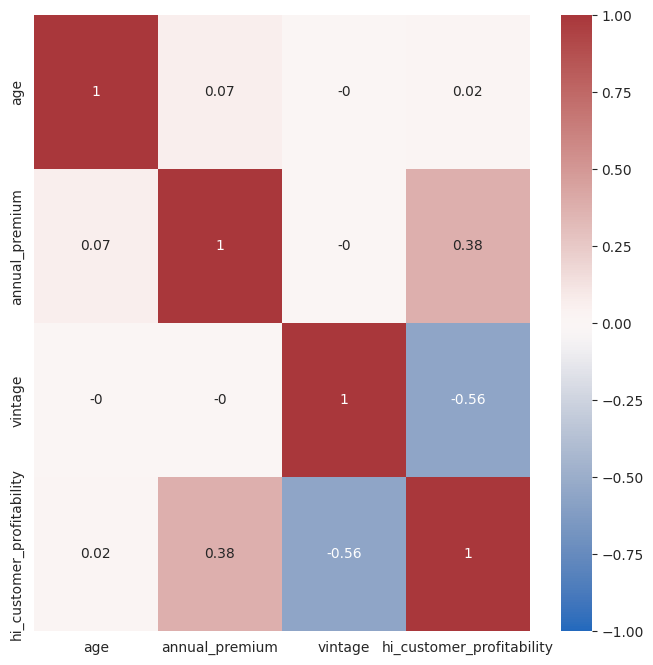

In [44]:
# Correlation matrix
corr = round(num_attributes2.corr(method='pearson'), 2)

# Heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='vlag');

Low correlation between other variables and an expected correlation between `hi_customer_profitability` vs `annual_premium` and vs `vintage`.

### 6.3.2. Categorical attributes

In [45]:
# Creating the confusion matrix of cramer v values
wanted_columns = cat_attributes2.columns
cm = pd.DataFrame(columns=wanted_columns)

for col1 in wanted_columns:
    v_values = []
    for col2 in wanted_columns:
        v = cramer_v(cat_attributes2[col1], cat_attributes2[col2])
        v_values.append(v)
    cm[col1] = v_values
cm = cm.set_index(wanted_columns)

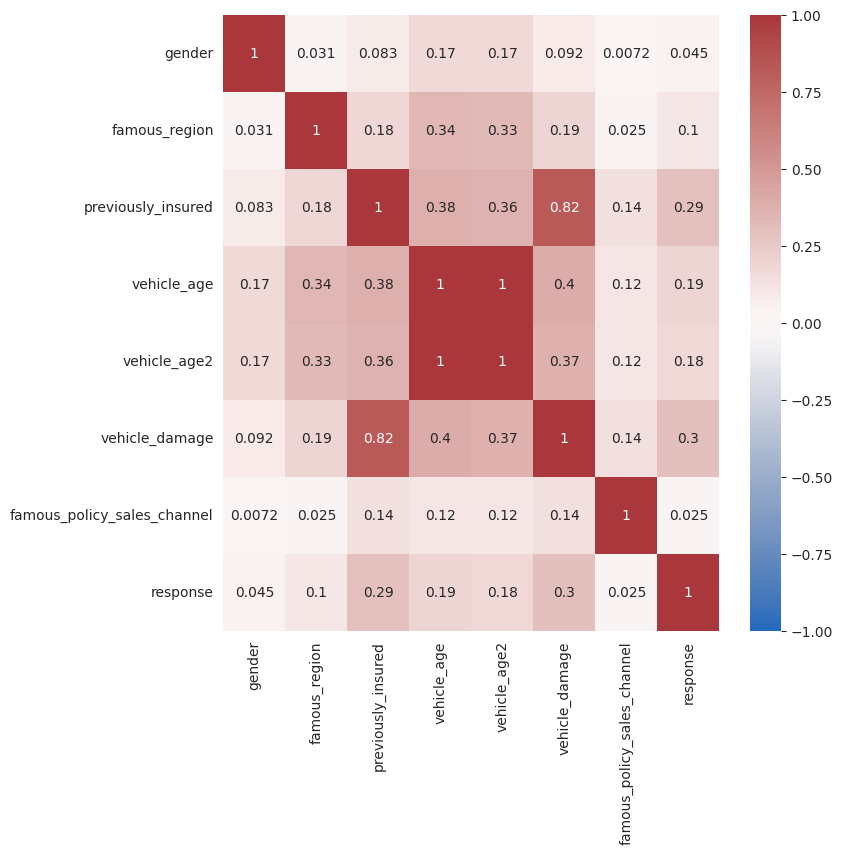

In [46]:
# Heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=-1, vmax=1, cmap='vlag');

- There is a high correlation between `vehicle_damage` and `previously_insured`
    - Maybe if the vehicle has been damaged, people tend to be more careful with their vehicles and get a vehicle insurance earlier
- `vehicle_age` is more correlated to other variables, when compared with `vehicle_age2`

# 7. DATA PREPARATION
---

In [27]:
# Copy
dfp = pd.read_csv('../data/interim/hi_cs_processed.csv')

## 7.1. Creating features

In [28]:
# Policy sales channel 2
dfp['policy_sales_channel2'] = dfp['policy_sales_channel'].copy().astype('int64').astype(str)
dfp.loc[~dfp['policy_sales_channel'].isin([152, 26, 124]), 'policy_sales_channel2'] = 'others'
dfp = pd.get_dummies(dfp, columns=['policy_sales_channel2'], dtype='int64')

# Drop policy_sales_channel and redundant policy_sales_channel2_others
dfp.drop(['policy_sales_channel', 'policy_sales_channel2_others'], axis=1, inplace=True)

## 7.2. Encoder

In [29]:
# Vehicle damage
dfp['vehicle_damage'] = dfp['vehicle_damage'].map({'Yes': 1, 'No': 0}).astype('int64')

# Gender (1 = male, 0 = female)
dfp['gender'] = dfp['gender'].map({'Male': 0, 'Female': 1}).astype('int64')

# Vehicle age
dfp['vehicle_age'] = dfp['vehicle_age'].map({'< 1 Year': 1, '1-2 Year': 2, '> 2 Years': 3}).astype('int64')

I'll test `vehicle_age` and `vehicle_age2` in feature importance methods. So, I'll include but drop one of them after.

## 7.3. Dropping some redundant features

In [30]:
# Order of variables and drop: region_code and previously_insured
wanted_vars = [
       'id', 'age', 'vehicle_damage', 'annual_premium', 'vintage',
       'famous_region', 'vehicle_age', 'vehicle_age2', 
       'hi_customer_profitability', 'famous_policy_sales_channel', 
       'policy_sales_channel2_124', 'policy_sales_channel2_152', 
       'policy_sales_channel2_26', 'gender', 'response'
]

dfp = dfp[wanted_vars]

There are 4 continuous and **10 categorical features**. Maybe **catboost** will be a good propose for algorithm!

In [31]:
# Saving the data before training division
dfp.to_csv('../data/interim/hi_cs_pre_training.csv', index=False)

## 7.4. Train and test datasets

In [32]:
# X and y
X = dfp.drop('response', axis=1)
y = dfp['response']

In [33]:
# Train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [34]:
# Saving X_train and y_train
X_train.to_csv('../data/processed/X_train.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)

# Saving X_test and y_test
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

## 7.5. Rescaling

I'll use some methods to rescale the data: **Min Max Scaler** and **Robust Scaler**. None of the continuous variables has a Normal distribution, aparently. If there are a lot of outliers, then Robust Scaler will be better. On the other hand, I'll use Min Max.

**SCALERS DEFINED:**

- **Min Max Scaler:**
    - `age`
    - `vintage`
- **Robust Scaler:**
    - `annual_premium`
    - `hi_customer_profitability`

In [35]:
# Define the scalers and the columns they should be applied to
scalers = [
    (MinMaxScaler(), ['age', 'vintage']),
    (RobustScaler(), ['annual_premium', 'hi_customer_profitability'])
]

# Define the column transformer with specified scalers
transformers = [(scaler.__class__.__name__.lower(), scaler, cols) for scaler, cols in scalers]
preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

# Apply rescaling to columns
X_train_rescaled = preprocessor.fit_transform(X_train)
X_test_rescaled = preprocessor.transform(X_test)

# Get feature names
X_train_cols = list(preprocessor.get_feature_names_out())
X_train_cols = [x.split('__')[1] for x in X_train_cols]

In [37]:
# Saving X_train_rescaled and X_test_rescaled
pd.DataFrame(X_train_rescaled, columns=X_train_cols)\
    .to_csv('../data/processed/X_train_rescaled.csv', index=False)
pd.DataFrame(X_test_rescaled, columns=X_train_cols)\
    .to_csv('../data/processed/X_test_rescaled.csv', index=False)

# 8. FEATURE SELECTION
---

In [40]:
# Import train and test data
X_train_rescaled = pd.read_csv('../data/processed/X_train_rescaled.csv')

X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')

X_test_rescaled = pd.read_csv('../data/processed/X_test_rescaled.csv')

X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

# Drop ID
for dataset in [X_train, X_test, X_train_rescaled, X_test_rescaled]:
    dataset.drop('id', axis=1, inplace=True)

# Data to numpy
X_train_rescaled_n = X_train_rescaled.values
y_train_n = y_train.values.ravel()

## 8.1. Boruta

I'll use Random Forest for Boruta algorithm. It's just a generalist forest model to input in.

In [16]:
## Boruta as feature selector - WARNING: 20 minutes to run
#
## Define the Boruta feature selector
#rfb = RandomForestClassifier(class_weight='balanced',            # class_weight='balanced' 
#                             max_depth=5, n_estimators=100)      # IS IMPORTANT FOR IMBALANCED DATA
#
#fs = BorutaPy(rfb, n_estimators='auto', random_state=42, 
#              verbose=2, max_iter=100)
#
## Fit the feature selector
#fs.fit(X_train_rescaled_n, y_train_n)
#
## Get the selected features
#selected_features = X_train.columns[fs.support_]
#print(selected_features)

In [20]:
boruta_features = [
    'age', 'annual_premium', 'vintage', 'famous_region', 'vehicle_age',
    'vehicle_age2', 'hi_customer_profitability',
    'famous_policy_sales_channel', 'policy_sales_channel2_124',
    'policy_sales_channel2_152', 'policy_sales_channel2_26', 'gender'
]

## 8.2. RF Feature Importances

In [17]:
# Fitting Random Forest
rffi = RandomForestClassifier(class_weight='balanced',            # class_weight='balanced' 
                              max_depth=5, n_estimators=100)      # IS IMPORTANT FOR IMBALANCED DATA

rffi.fit(X_train_rescaled, y_train_n)

RandomForestClassifier(class_weight='balanced', max_depth=5)

In [18]:
# Feature Importances
rf_imp_features = pd.Series(rffi.feature_importances_, index=X_train_rescaled.columns)
rf_imp_features = rf_imp_features.sort_values()

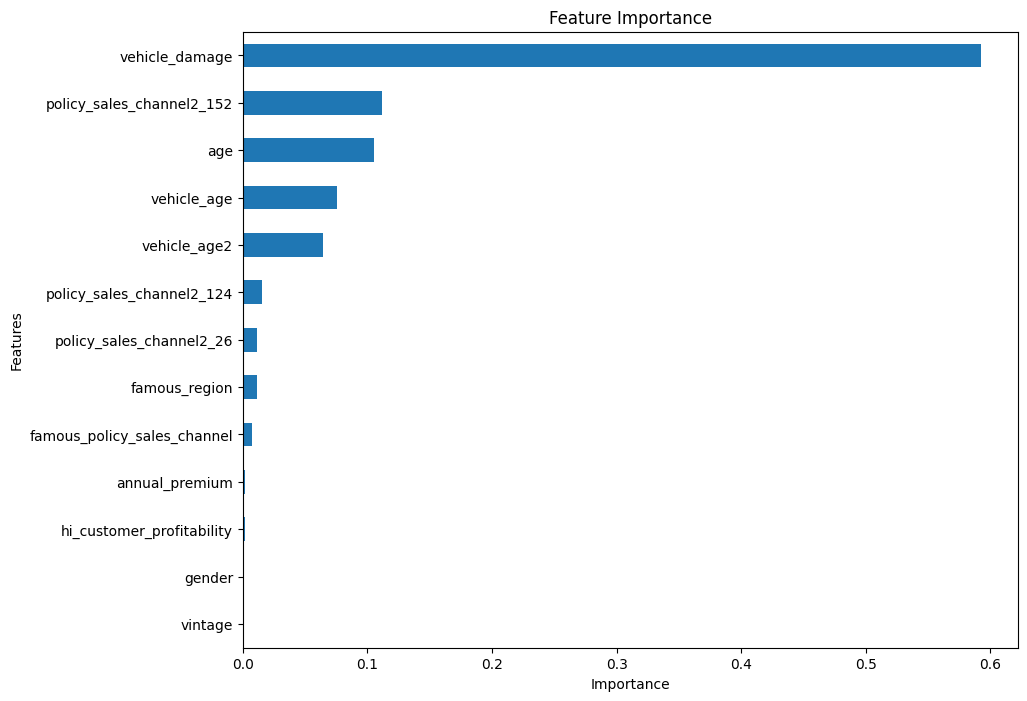

In [19]:
# Plot feature importances
plt.figure(figsize=(10, 8))
rf_imp_features.plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In Random Forest feature importances:
- `vehicle_age2` was less important than `vehicle_age`
- `famous_policy_sales_channel` was less important than the `152`, `124` and `26` channels separately
- The most important variable is `vehicle_damage`

## 8.3. SHAP Values

In [7]:
# Fitting Random Forest
rfs = RandomForestClassifier(class_weight='balanced',            # class_weight='balanced' 
                             max_depth=5, n_estimators=100)      # IS IMPORTANT FOR IMBALANCED DATA

rfs.fit(X_train_rescaled, y_train_n)

# Initialize explainer with the training data
explainer = shap.TreeExplainer(rfs)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_rescaled)

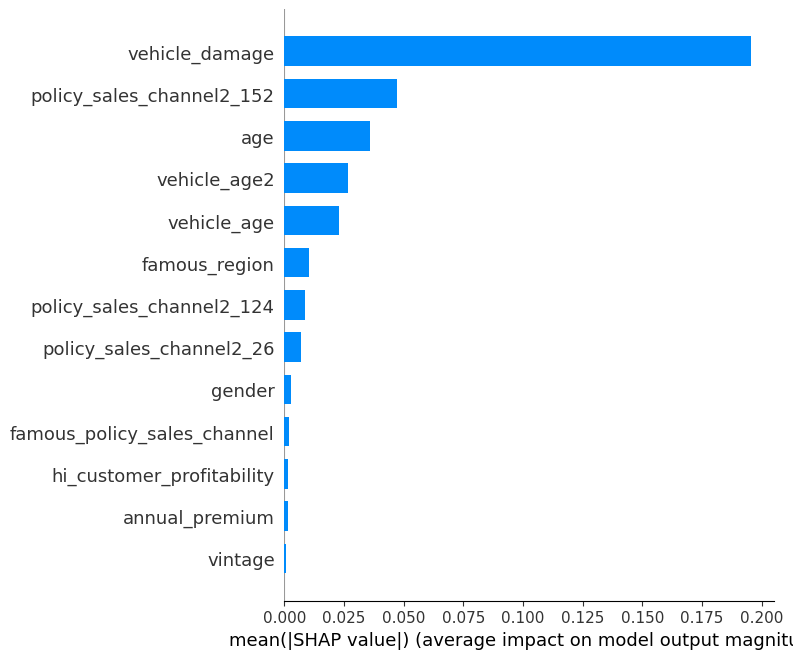

In [8]:
# SHAP feature importance plot
shap.summary_plot(shap_values[:,:,1], X_train_rescaled,
                  feature_names=X_train_rescaled.columns,
                  plot_type='bar')
plt.show()

`vehicle_age2` and `vehicle_age` have almost the same importance...

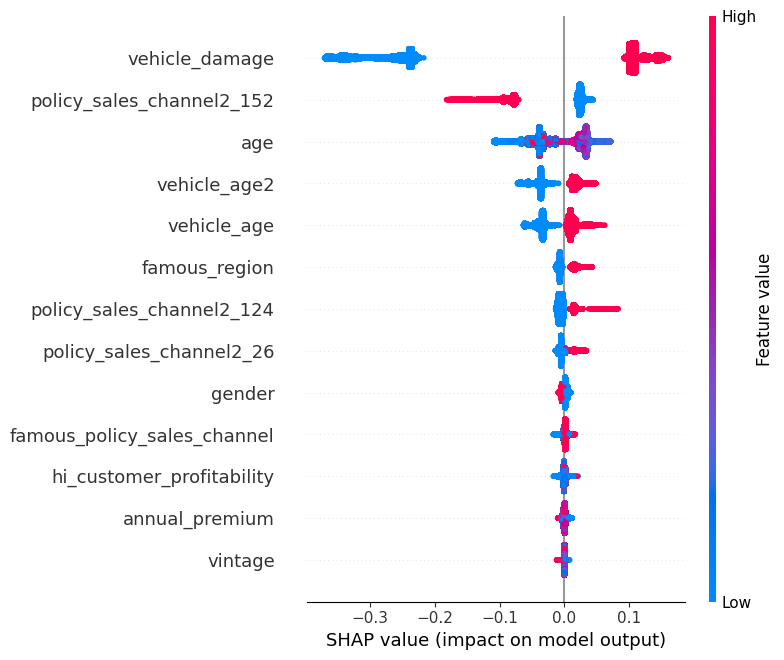

In [9]:
# SHAP beeswarm plot
shap.summary_plot(shap_values[:,:,1], X_train_rescaled,
                  feature_names=X_train_rescaled.columns)
plt.show()

## 8.4. Decision

From **EDA**, **RF Feature Importances** and **SHAP plots**, the less important features are:
- `vintage`
- `hi_customer_profitability`
- `annual_premium`

I won't drop `gender` because maybe it is important for this business case.

Furthermore, there are some features high correlated with others:
- `famous_policy_sales_channel`: `152`, `124` and `26`
- `vehicle_age2`: `vehicle_age` (I could choose any of them)

So, I'll drop `famous_policy_sales_channel` and `vehicle_age2`.

# 9. MACHINE LEARNING MODELING
---

In [5]:
# Final X features
final_x_feat = [
    'age', 'gender', 'famous_region',
    'vehicle_damage', 'vehicle_age',
    'policy_sales_channel2_124',
    'policy_sales_channel2_152', 
    'policy_sales_channel2_26'
]

# Define the scalers and the columns they should be applied to
scalers = [
    (MinMaxScaler(), ['age'])
]

In [6]:
# Import train and test data
X_train_rescaled = pd.read_csv('../data/processed/X_train_rescaled.csv')
X_train_ids = X_train_rescaled['id'].values

X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')

X_test_rescaled = pd.read_csv('../data/processed/X_test_rescaled.csv')
X_test_ids = X_test_rescaled['id'].values

X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

# Drop ID
for dataset in [X_train, X_test, X_train_rescaled, X_test_rescaled]:
    dataset.drop('id', axis=1, inplace=True)
    dataset = dataset[final_x_feat]

# Data to numpy
X_train_rescaled_n = X_train_rescaled.values
y_train_n = y_train.values.ravel()

There are **7 categorical** and **1 numerical** features. I think that **CatBoost** will be a good model to try! I'll see other models too, like **Random Forest**, **XGBoost**, **Extra Trees**, **KNN** and **Logistic Regression**.

In [10]:
# Calculate the ratio of negative class to positive class
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]

# Define the models
xgb = XGBClassifier(scale_pos_weight=ratio, max_depth=6)
rf = RandomForestClassifier(class_weight='balanced', max_depth=6)
lr = LogisticRegression(class_weight='balanced')
et = ExtraTreesClassifier(class_weight='balanced', max_depth=6)
knn = KNeighborsClassifier(n_neighbors=7)

cb = CatBoostClassifier(
    iterations=1000,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=5,  # Depth of the trees
    l2_leaf_reg=3,  # L2 regularization term
    eval_metric='AUC',  # Evaluation metric
    auto_class_weights='Balanced',  # Automatically adjust weights for classes to balance
    random_seed=42,  # Random seed for reproducibility
    logging_level='Silent'  # Suppress training log
)

models = [cb, xgb, rf, lr, et, knn]

In [11]:
# Define the metric
metrics = [roc_auc_score, precision_score, recall_score, f1_score]

# Metrics results
results_cv_df = make_cv_model_results_df(models, X_train_rescaled, y_train_n, metrics, scalers)

In [12]:
display(results_cv_df)

,model,roc_auc_cv,precision_cv,recall_cv,f1_cv
0,CatBoostClassifier,0.773 +/- 0.002,0.207 +/- 0.001,0.894 +/- 0.004,0.336 +/- 0.002
1,XGBClassifier,0.77 +/- 0.001,0.207 +/- 0.001,0.882 +/- 0.002,0.336 +/- 0.001
2,RandomForestClassifier,0.774 +/- 0.002,0.205 +/- 0.001,0.903 +/- 0.005,0.334 +/- 0.002
3,LogisticRegression,0.764 +/- 0.002,0.193 +/- 0.001,0.914 +/- 0.003,0.319 +/- 0.001
4,ExtraTreesClassifier,0.77 +/- 0.002,0.205 +/- 0.001,0.888 +/- 0.005,0.333 +/- 0.002
5,KNeighborsClassifier,0.517 +/- 0.001,0.245 +/- 0.003,0.051 +/- 0.001,0.084 +/- 0.002


In [51]:
results_test_df = pd.DataFrame(columns=['model', 'precision_test', 
                                        'recall_test', 'f1_test'])
auc_tests = []
test_models = []
precision_tests = []
recall_tests = []
f1_tests = []

# Fitting all the models for test set
for model in models:
    model.fit(X_train_rescaled, y_train_n)
    y_pred = model.predict(X_test_rescaled)
    y_pred_proba = model.predict_proba(X_test_rescaled)
    
    # Scores of test data and save results
    m_str = model.__class__.__name__
    auc = round(roc_auc_score(y_test, y_pred_proba[:,1]), 3)
    p = round(precision_score(y_test, y_pred, zero_division=1), 3)
    r = round(recall_score(y_test, y_pred, zero_division=1), 3)
    f1 = round(f1_score(y_test, y_pred, zero_division=1), 3)

    aucs.append(auc)
    test_models.append(m_str)
    precision_tests.append(p)
    recall_tests.append(r)
    f1_tests.append(f1)

# Fill results_test_df
results_test_df['model'] = test_models
results_test_df['auc_test'] = auc_tests
results_test_df['precision_test'] = precision_tests
results_test_df['recall_test'] = recall_tests
results_test_df['f1_test'] = f1_tests

In [55]:
# Final results df
results_df = results_cv_df.merge(results_test_df, on='model', how='left')

# Ordering variables
results_df = results_df[['model', 'roc_auc_cv', 'auc_test',
                         'precision_cv', 'precision_test',
                         'recall_cv', 'recall_test',
                         'f1_cv', 'f1_test']]

In [56]:
display(results_df)

,model,roc_auc_cv,auc_test,precision_cv,precision_test,recall_cv,recall_test,f1_cv,f1_test
0,CatBoostClassifier,0.773 +/- 0.002,0.828,0.207 +/- 0.001,0.207,0.894 +/- 0.004,0.900,0.336 +/- 0.002,0.337
1,XGBClassifier,0.77 +/- 0.001,0.826,0.207 +/- 0.001,0.208,0.882 +/- 0.002,0.888,0.336 +/- 0.001,0.336
2,RandomForestClassifier,0.774 +/- 0.002,0.826,0.205 +/- 0.001,0.204,0.903 +/- 0.005,0.897,0.334 +/- 0.002,0.333
3,LogisticRegression,0.764 +/- 0.002,0.817,0.193 +/- 0.001,0.195,0.914 +/- 0.003,0.917,0.319 +/- 0.001,0.321
4,ExtraTreesClassifier,0.77 +/- 0.002,0.823,0.205 +/- 0.001,0.206,0.888 +/- 0.005,0.883,0.333 +/- 0.002,0.334
5,KNeighborsClassifier,0.517 +/- 0.001,0.734,0.245 +/- 0.003,0.240,0.051 +/- 0.001,0.049,0.084 +/- 0.002,0.081


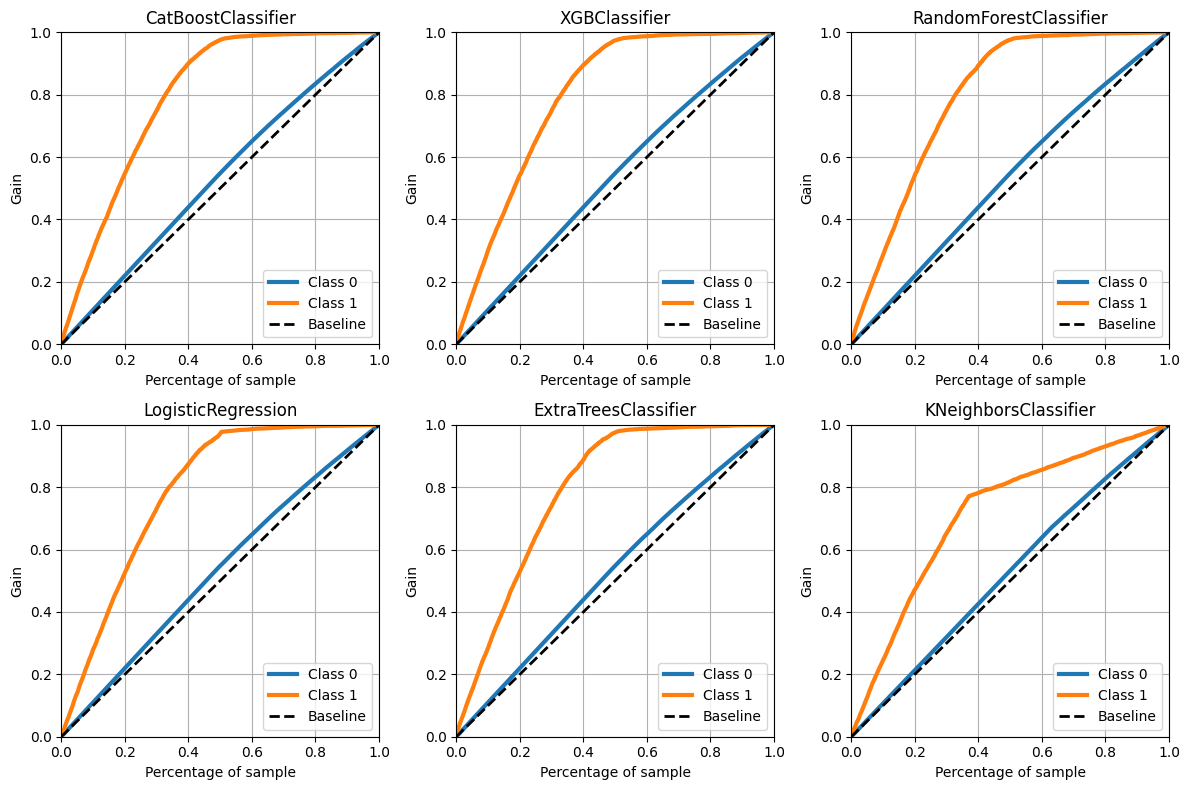

In [29]:
# All cumulative gain plots
plot_cumulative_gain_of(models, X_test_rescaled, y_test)